The viscosity of a shear-thinning fluid can be defined as:

$\eta(\dot{\gamma}) = \eta_{\infty} + (\eta_0 - \eta_{\infty}) * [1 + (\lambda \dot{\gamma})^a]^{(n-1) / a}$

where $\dot{\gamma}$ is the shear rate, and it is defined as $\dot{\gamma}(y) = \left|\frac{dv_x}{dy}\right|_y$.

The velocity profile of a fluid between two plates separated by a distance of $B$ defined by that equation is defined by this boundary value differential equation:

$\eta(\dot{\gamma}) \frac{dv_x}{dy} = \left(\frac{\Delta P}{\Delta x}\right)\left(y - \frac {B}{2} \right)$.

where $v_x(0) = 0$, and $v_x(B) = 0$.

For this problem, let $B = 0.1$ m, $\Delta P/\Delta x = -1,184,000$, Pa/m,  $\eta_{\infty} = 0.0, \eta_0 = 1.484e4$  Pa &sdot; s, $a=2, n=0.398$. This describes the viscosity of molten polystyrene at 453K. Our goal is to find the velocity profile between the plates.

You cannot solve this problem with `scipy.integrate.solve_bvp` because the viscosity depends on the derivative, and it is not possible to solve for the derivative as a function of only $y, v_x$. Instead, you have to use finite differences to discretize the problem and then solve the corresponding nonlinear algebra equations.

To estimate the derivative at each grid point, you should use the centered difference formula, which assumes a uniform spacing between the $y$ points of $h$:

$\frac{dv_x}{dy} \approx \frac{v_x[i + 1] - v_x[i - 1]}{2 h}$

For the initial guess, you can use the analytical solution for a Newtonian fluid:

$v_x(y) = \frac{y (y - B)}{2 \eta_0}\left(\frac{\Delta P}{\Delta x}\right)$.

Find a solution to the BVP that shows the velocity of the fluid between the two plates. Plot your solution and compare it to the solution for a Newtonian fluid.



Given your solution, estimate the viscosity as a function of $y$ between the plates.



### solution



Here we setup the discretized equations and solve them.



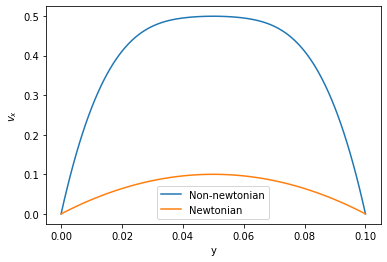

In [16]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

eta_inf = 0.0
eta_0 = 1.48e4
_lambda = 1.04
n = 0.398
a = 2

B = 0.1 # m
dPdX= -1184000  # Pa-m

def eta(gdot):
    return (1 + (_lambda * gdot)**a)**((n - 1) / a) * (eta_0 - eta_inf) + eta_inf


y, h = np.linspace(0, B, 100, retstep=True)

guess = y * (y - B) / 2 / eta_0 * dPdX


def residuals(vx):
    N = len(vx)
    res = np.zeros(y.shape)

    res[0] = vx[0]
    for i in range(1, N - 1):
        dvxdy = (vx[i+1] - vx[i - 1]) / (2* h)
        gammadot = np.abs(dvxdy)
        res[i] = eta(gammadot) * dvxdy - dPdX * (y[i] - B / 2)

    res[-1] = vx[-1]

    return res



from scipy.optimize import fsolve

sol = fsolve(residuals, guess)
plt.plot(y, sol)
plt.plot(y, guess)
plt.xlabel('y')
plt.ylabel('$v_x$')
plt.legend(['Non-newtonian', 'Newtonian'])

Here we get the gradient and compute the viscosity.



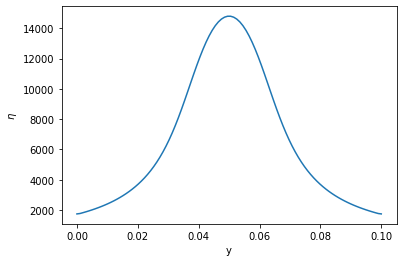

In [8]:
dvxdy = np.gradient(sol, y)
plt.plot(y, eta(np.abs(dvxdy)))
plt.xlabel('y')
plt.ylabel(r'$\eta$');

# What if you use an odd number of points?

If you use an odd number of points with the code above, for some reason you do not get a solution. You can see that here. Keep reading to see how to fix it.

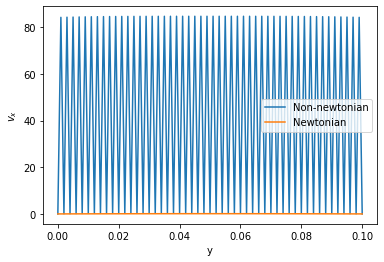

In [21]:
y, h = np.linspace(0, B, 101, retstep=True)

guess = y * (y - B) / 2 / eta_0 * dPdX


def residuals(vx):
    N = len(vx)
    res = np.zeros(y.shape)

    res[0] = vx[0]
    for i in range(1, N - 1):
        dvxdy = (vx[i+1] - vx[i - 1]) / (2* h)
        gammadot = np.abs(dvxdy)
        res[i] = eta(gammadot) * dvxdy - dPdX * (y[i] - B / 2)

    res[-1] = vx[-1]

    return res



from scipy.optimize import fsolve

sol = fsolve(residuals, guess)
plt.plot(y, sol)
plt.plot(y, guess)
plt.xlabel('y')
plt.ylabel('$v_x$')
plt.legend(['Non-newtonian', 'Newtonian'])

The problem seems to be related to the boundary conditions. Above, we just set the equations to zero at the boundaries, which does not seem to work. If we instead use the equations at at least one point, then it does work. 

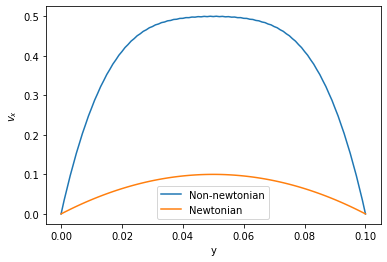

In [23]:
eta_inf = 0.0
eta_0 = 1.48e4
_lambda = 1.04
n = 0.398
a = 2

B = 0.1 # m
dPdX= -1184000  # Pa-m

def eta(gdot):
    return (1 + (_lambda * gdot)**a)**((n - 1) / a) * (eta_0 - eta_inf) + eta_inf


y, h = np.linspace(0, B, 101, retstep=True)

guess = y * (y - B) / 2 / eta_0 * dPdX


def residuals(vx):
    N = len(vx)
    res = np.zeros(y.shape)

    # This does not work for odd points
    #res[0] = vx[0] # we want this to be zero for no-slip
    
    # Instead, we estimate the derivative at the begining for a forward difference formula.
    res[0] = eta(vx[1] / h) * vx[1] / h - dPdX * (y[0] - B / 2)
    
    for i in range(1, N - 1):
        dvxdy = (vx[i + 1] - vx[i - 1]) / (2 * h)
        gammadot = np.abs(dvxdy)
        res[i] = eta(gammadot) * dvxdy - dPdX * (y[i] - B / 2)

    # it seems ok to leave this one here, but we can also replace it with a backward difference below.
    # res[-1] = vx[-1] # we want this to be zero for no-slip

    dvxdy = (vx[-1] - vx[-2]) / h
    res[-1] = eta(np.abs(dvxdy)) * dvxdy - dPdX * (y[-1] - B / 2)
    return res

sol = fsolve(residuals, guess)
plt.plot(y, sol)
plt.plot(y, guess)
plt.xlabel('y')
plt.ylabel('$v_x$')
plt.legend(['Non-newtonian', 'Newtonian'])